# 从线性回归到线性分类

| ![](../../_static/logo/megvii-32.svg) [在 MegStudio 运行](https://studio.brainpp.com/project/4643) | ![](../../_static/logo/github-32.svg) [查看源文件](https://github.com/MegEngine/Documentation/blob/main/source/getting-started/beginner/from-linear-regression-to-linear-classification.ipynb) |
| --- | --- |

回归和分类问题在机器学习中十分常见，我们接触过了线性回归，那么线性模型是否可用于分类任务呢？本次教程中，我们将：

- 接触经典的 MNIST 数据集和对应的分类任务，对计算机视觉领域的图像编码有一个基础认知；
- 将线性回归经过“简单改造”，则可以用来解决分类问题——我们将接触到 Logistic 回归和 Softmax 回归；
- 结合之前的学习，**实现一个最简单的线性分类器，并尝试用它来识别手写数字。**

请先运行下面的代码，检验你的环境中是否已经安装好 MegEngine（[访问官网安装教程](https://megengine.org.cn/install)）：

In [1]:
import megengine

print(megengine.__version__)

1.4.0


接下来，我们将先了解一下这次要使用到的分类问题经典数据集：[MNIST 手写数字数据集](http://yann.lecun.com/exdb/mnist/)。

## MNIST 手写数字数据集

MNIST 的训练数据集中存在着 60000 张（测试集 10000 张）手写数字 0～9 的黑白图片样例，每张图片的长和宽均为 28 像素。

在 MegEngine 的 `dataset` 模块中内置了 MNIST 等经典数据集的接口，方便初学者进行相关调用：

In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from megengine.data.dataset import MNIST

# 强烈推荐使用 MegStudio 平台，可在项目设置中直接选用 MNIST 数据集，无需再进行下载
# 如果使用 MegStudio 环境，请将 MNIST_DATA_PATH 为 /home/megstudio/dataset/MNIST/
MNIST_DATA_PATH = "/data/datasets/MNIST/"

# 国内网络环境从 MNIST 数据集官方主页下载数据集可能会有些慢，可人为下载好以下文件后，放置在 MNIST_DATA_PATH 对应的路径
#     t10k-images-idx3-ubyte.gz
#     t10k-labels-idx1-ubyte.gz
#     train-images-idx3-ubyte.gz
#     train-labels-idx1-ubyte.gz

# 获取训练数据集，如果本地没有数据集，请将 download 参数设置为 True
train_dataset = MNIST(root=MNIST_DATA_PATH, train=True, download=False)

01 18:24:17 process the raw files of train set...
100%|████████████████████████████████| 60000/60000 [00:00<00:00, 1653210.01it/s]


以训练集为例，你最终将得到一个长度为 60000 的 `train_dataset` 列表，其中的每个元素是一个包含样本和标签的元组：

In [3]:
print(train_dataset.meta)
print(len(train_dataset), type(train_dataset[0]))
print(len(train_dataset[0]), train_dataset[0][0].shape, train_dataset[0][1].shape)

{'images': {'magic': 2051, 'imgs': 60000, 'height': 28, 'width': 28}, 'labels': {'magic': 2049, 'imgs': 60000}}
60000 <class 'tuple'>
2 (28, 28, 1) ()


为了方便理解，我们这里选择将数据集拆分为样本和标签，处理成 Numpy 的 ndarray 格式：

In [4]:
train_data = np.array([t[0] for t in train_dataset])
train_label = np.array([t[1] for t in train_dataset])
print(train_data.shape, train_label.shape)

(60000, 28, 28, 1) (60000,)


经过上面的整理，我们得到了训练数据 `train_data` 和对应的标签 `train_label`:

- 可以发现此时的训练数据的形状是 $(60000, 28, 28, 1)$, 分别对应数据量（Number）、高度（Height）、宽度（Width）和通道数（Channel），简记为 NHWC；
- 其中通道（Channel）是图像领域常见的概念，对计算机而言，1 通道通常表示灰度图（Grayscale），即将黑色到白色之间分为 256 阶表示；
- 布局（Layout）表示了数据在内存中的表示方式，在 MegEngine 中，通常以 NCHW 作为默认的数据布局，我们在将来会接触到布局的转换。

### 理解黑白（灰度）图像数据

我们先尝试对数据进行随机抽样，并进行可视化显示：

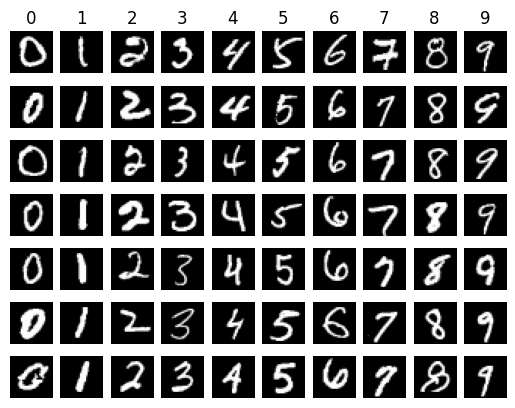

In [5]:
classes = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
num_classes = len(classes)
samples_per_class = 7

# 注意：初学者在接触本小节的可视化代码时可不求甚解，只在意其展示效果并阅读后面的部分，学有余力者可尝试搞清楚代码细节。
for y, cls in enumerate(classes):
    idxs = np.squeeze(np.where(train_label == y))
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(train_data[idx], cmap="gray")
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

挑选出一张图片（下方的 `idx` 可修改），进行二维和三维视角的可视化：

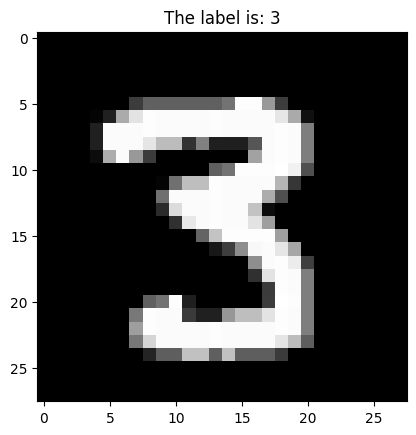

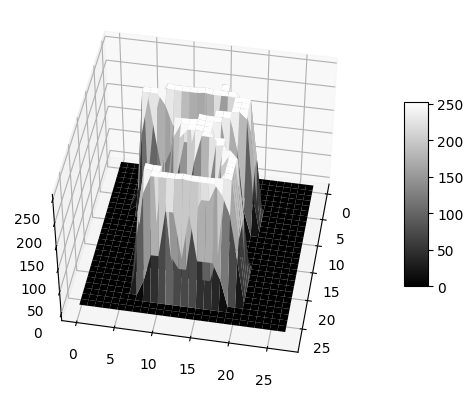

In [6]:
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter

idx = 28204 # 可以修改这个值
plt.title("The label is: %s" % train_label[idx])
plt.imshow(train_data[idx], cmap="gray")
plt.show()

# 注意：初学者在接触本小节的可视化代码时可不求甚解，只在意其展示效果并阅读后面的部分，学有余力者可尝试搞清楚代码细节。
ax = plt.axes(projection='3d')
ax.set_zlim(-10, 255)
ax.view_init(elev=45, azim=10)
X, Y = np.meshgrid(np.arange(28), np.arange(28))
Z = np.squeeze(train_data[idx])
surf = ax.plot_surface(Y, X, Z, cmap="gray")
plt.colorbar(surf, shrink=0.5, aspect=8)
plt.show()

在灰度图中，每个像素值用 0（黑色）~ 255（白色）进行表示，即一个 `int8` 所能表示的范围。

### 图像数据的特征向量表示

回想一下我们在使用波士顿房价数据集时，单个样本的特征通常以特征向量 $\mathbf {x} \in \mathbb R^D$ 的形式进行表示，而图像的样本特征空间为 $\mathbf {x} \in \mathbb R ^{H \times W \times C}$。

对于图像类型的数据输入，在没有想到更好的特征抽取和表征形式时，不妨也粗线条一些，考虑直接将像素点“铺”成向量的形式，即 $\mathbb R ^{H \times W \times C} \mapsto \mathbb R^D$：

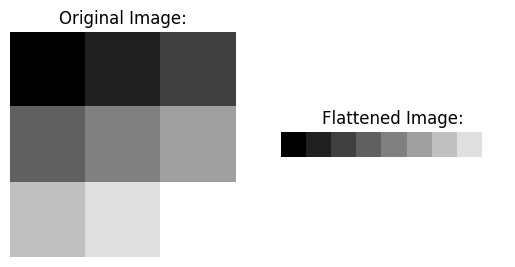

In [7]:
original_image = np.arange(0, 256, 256/9).reshape((3, 3, 1))
flattened_image = original_image.reshape((1, -1)) # 铺成一个行向量

plt.subplot(121)
plt.axis('off')
plt.title("Original Image:")
plt.imshow(original_image, cmap="gray")

plt.subplot(122)
plt.axis('off')
plt.title("Flattened Image:")
plt.imshow(flattened_image, cmap="gray")
plt.show()

上面是一个简单的例子，这种扁平化（Flatten）的操作同样也可以对整个 `train_data` 使用：

In [8]:
nums = train_data.shape[0]
train_data = train_data.reshape((nums, -1)) # 缺省值 -1 表示自动计算剩下的维度 28 x 28 x 1 = 784
print(train_data.shape)

(60000, 784)


在 MegEngine 的 `functional` 模块中，提供了 `flatten()` 方法：

In [9]:
from megengine import tensor
import megengine.functional as F

x = tensor(np.random.random((10, 28, 28, 1)))
out = F.flatten(x, start_axis=1, end_axis=-1)  # 将从 start_axis 维到 end_axis 维的子张量展平
print(x.shape)
print(out.shape)

(10, 28, 28, 1)
(10, 784)


这样的话，就可以把问题和我们所了解的线性回归模型 $f(\mathbf {x}) = \mathbf {w} \cdot \mathbf {x} + b$ 联系起来了，但情况有那么一些不同：

线性回归的输出值在 $\mathbb R$ 上连续，并不能很好的处理标签值离散的多分类问题，因此需要寻找新的解决思路。

## 线性分类模型

我们先从较为简单的二分类问题，即标签 $y \in \{0, 1\}$ 情况开始讨论，再将情况推广到多分类。

对于离散的标签，我们可以引入非线性的决策函数 $g(\cdot)$ 来预测输出类别（决策边界依然是线性超平面，依旧是线性模型）。

举个例子，可以将 $f(\mathbf {x}) = \mathbf {x} \cdot \mathbf {w} + b$ 的输出以 0 为阈值（threshold）做划分（即此时决策边界为 $f(\mathbf {x}) = 0$），决策函数为指示函数 $\mathbb{I}(\cdot)$：

$$
\hat {y} = \mathbb{I}(f(\mathbf {x}) - \text{threshold})=\left\{\begin{array}{lll}
1 & \text {if} & f(\mathbf {x})>\text{threshold} \\
0 & \text {if} & f(\mathbf {x})<\text{threshold}
\end{array}\right.
$$

这种决策方法虽然简单直观，但缺点也很明显：

- 如果看成是一个优化问题，它的数学性质导致其不适合用于梯度下降算法；
- 如果数据集不同的类别之间没有明确的关系，分段决策在多分类的情况下不适用；
  - 比如手写数字分类，将输出值平均到 0～9 附近，依据四舍五入分类，不同分类之间存在着“距离度量”；
  - 这暗示着不同的分类之间也有相似度/连续性，则等同于假设图像 1 和图像 2 的相似度会比 1 和 7 的相似度更高

### Logistic 回归

Logistic 回归是一种常见的处理二分类问题的线性模型，使用 Sigmoid 函数 $\sigma (\cdot)$ 作为决策函数（其中 `exp()` 指以自然常数 $e$ 为底的指数函数）：

$$
\sigma (x) = \frac{1}{1+\exp( -x)}
$$

Sigmoid 这样的 S 型函数最早被人们设计出来并使用，它有如下优点：

- Sigmoid 函数的导数非常容易求出：$\sigma '(x) = \sigma (x)(1- \sigma (x))$, 其处处可微的性质保证了在优化过程中梯度的可计算性；
- Sigmoid 函数还可以将值压缩到 $(0, 1)$ 范围内，很适合用来表示预测结果是某个分类的概率：

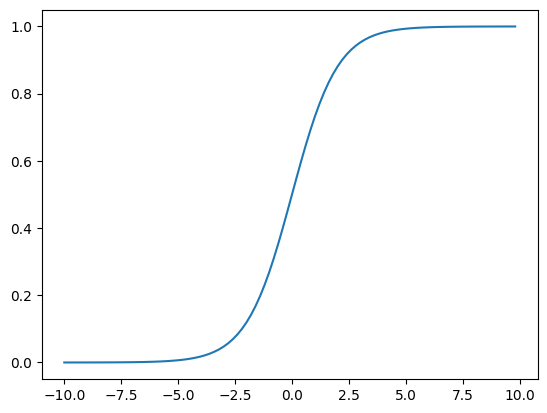

In [10]:
def sigmoid(x):
    return 1. / (1. + np.exp(-x))

x = np.arange(-10, 10, 0.2)
y = sigmoid(x)
plt.plot(x, y)
plt.show()

历史小知识：Logistic 是比利时数学家 Pierre François Verhulst 在 1844 或 1845 年在研究人口增长的关系时命名的，和 Sigmoid 一样指代 S 形函数：起初阶段大致是指数增长；然后随着开始变得饱和，增加变慢最后，达到成熟时增加停止。以下是 Verhulst 对命名的解释：

> “We will give the name logistic [logistique] to the curve" (1845 p.8). Though he does not explain this choice, there is a connection with the logarithmic basis of the function. Logarithm was coined by John Napier (1550-1617) from Greek logos (ratio, proportion, reckoning) and arithmos (number). Logistic comes from the Greek logistikos (computational). In the 1700's, logarithmic and logistic were synonymous. Since computation is needed to predict the supplies an army requires, logistics has come to be also used for the movement and supply of troops. So it appears the other meaning of "logistics" comes from the same logic as Verhulst terminology, but is independent (?). Verhulst paper is accessible; the definition is on page 8 (page 21 in the volume), and the picture is after the article (page 54 in the volume). ” —— [Why logistic (sigmoid) ogive and not autocatalytic curve?](https://rasch.org/rmt/rmt64k.htm)

在 MegEngine 的 `functional` 模块中，提供了 `sigmoid()` 方法：

In [11]:
inp_ndarray = np.array([1., 2., 3.])
print(sigmoid(inp_ndarray))  # 这里调用了上面实现的 NumPy 版本 Sigmoid

inp_tensor = tensor([1., 2., 3.])
print(F.sigmoid(inp_tensor).numpy())

[0.73105858 0.88079708 0.95257413]
[0.7310586  0.880797   0.95257413]


根据二分类问题 $y \in \{0, 1\}$ 的特性，标签值不是 $1$ 即是 $0$，可以使用如下形式表示预测分类为 $1$ 或 $0$ 的概率：

$$
\begin{aligned}
p(y=1 \mid \mathbf {x}) &= \sigma (f(\mathbf {x})) = \frac{1}{1+\exp \left( -f(\mathbf {x}) \right)} \\
p(y=0 \mid \mathbf {x}) &= 1 - p(y=1 \mid \mathbf {x})
\end{aligned}
$$

在处理二分类问题时，我们进行优化的最终目的是，希望最终预测的概率值 $\hat{y}=\sigma(f(\mathbf x))$ 尽可能地接近真实标签 $y$;

为了能够正确地优化我们的任务目标，需要选用合适的损失（目标）函数。有了线性回归的经验，不妨用均方误差 MSE 试一下：

$$
\begin{aligned}
\ell_{\operatorname{MSE}} &= \frac {1}{2} \sum_{n} \left( \hat{y} - y \right )^2 \\
\frac {\partial (\hat{y} - y)^2}{\partial \mathbf {w}} &= 
2 (\hat{y} - y) \cdot \frac {\partial \hat{y}}{\partial f(\mathbf {x})} 
\cdot \frac {\partial f(\mathbf {x})}{\partial w} \\
&= 2 (\hat{y} - y) \cdot \color{blue} {\hat{y} \cdot (1 - \hat{y})} \cdot \color{black} {\mathbf {x}}
\end{aligned}
$$

- 虽然可以求得相应的梯度，但随着参数的更新，单样本上求得的梯度越来越接近 $0$, 即出现了梯度消失（Gradient Vanishing）的情况；
- 另外使用 Sigmoid + MSE 得到的是一个非凸函数（可通过求二阶导证明），使用梯度下降算法容易收敛到局部最小值点，而非全局最优点。

所以应该设计什么样的损失函数，才是比较合理的呢？在揭晓答案之前，我们先直接将二分类问题推广到多分类的情况。

### Softmax 回归

Softmax 回归可以看成是 Logistic 回归在多分类问题上的推广，也称为多项（Multinomial）Logistic 回归，或多类（Muti-Class）Logistic 回归。

对于多分类问题，类别标签 $y \in \{1, 2, \ldots, C \}$ 可以有 $C$ 个取值 —— 前面提到，如何将我们的输出和这几个值较好地对应起来，是需要解决的难题之一。

在处理二分类问题时，我们使用 Sigmoid 函数将输出变成了 $(0,1)$ 范围内的值，将其视为概率。对于多分类问题的标签，我们也可以进行形式上的处理。

我们可以将真实的类别标签值 $y$ 处理成 One-hot 编码的形式进行表示：只在对应的类别标签位置为 1，其它位置为 0.

在 MegEngine 的 `functional` 模块中，提供了 `one_hot()` 方法：

In [12]:
# 举例：某张手写数字图片的对应标签为 3，进行 one-hot 编码表示
inp = tensor([3])
out = F.one_hot(inp, num_classes=10)
print(out.numpy()) # 输出是 2-D 的，因为将数量 n 也包括进去了，此时 n=1

# 也可以选择将整个 train_label 转换成 one_hot 编码
print(F.one_hot(tensor(train_label), num_classes=10).shape)

[[0 0 0 1 0 0 0 0 0 0]]
(60000, 10)


不难发现，One-hot 编码以向量 $\mathbf y$ 的形式给出了样本属于每一个类别的概率。

自然地，我们希望线性分类器最终输出的预测值是一个形状为 $(C,)$ 的向量 $\hat {\mathbf y}$，这样方便设计和计算损失函数。

- 我们已经知道线性输出 $\hat y = f(\mathbf x; \mathbf w, b) = \mathbf x \cdot \mathbf w + b \in \mathbb R$ , 现在我们希望能够得到 $\hat {\mathbf y} \in \mathbb R^C$ 这样的输出;
- 可以设计 $C$ 个不同的 $f(\mathbf x; \mathbf w, b$) 分别进行计算得到 $C$ 个输出，也可以直接利用矩阵 $W$ 和向量 $b$ 的形式直接计算：

In [13]:
np.random.seed(0)  # 设置随机种子，每次可以得到一样的随机值

x = train_data[0]
num_features = x.shape[0]
num_classes = 10

w = np.random.random((num_features,))
b = np.random.random(())
y_reg = np.dot(x, w) + b
print(y_reg, y_reg.shape)

W = np.random.random((num_features, num_classes))
b = np.random.random((num_classes, ))
y_cls = np.dot(x, W) + b
print(y_cls, y_cls.shape)

13044.699427857662 ()
[13469.6227653  13984.33880404 13222.26198744 14459.78086955
 13531.92700947 13761.72257265 13721.3955121  13568.95728431
 14097.15055322 13401.91409062] (10,)


得到的输出虽然有  $C$ 个值了，但仍然不是概率的形式，这时我们希望设计这样一个决策函数：

- 通过这个函数，可以将输出的 $C$ 个值转换为样本 $\mathbf{x}$ 属于某一类别 $c$ 的概率 $p(y=c | \mathbf{x}) \in (0,1)$；
- 满足不同预测标签类别的概率和为 1. 

一个直接的想法是使用 $\operatorname{ArgMax}$ 函数，将对应位置的概率设置为 1，其它位置为 0

- 这样也可以得到作为最终预测的 One-hot 编码形式的向量，但问题在于：
- 和分段函数类似，此时的 $\operatorname{ArgMax}$ 函数是不可导的，对梯度下降法不友好；
- 这种处理方式过于简单粗暴，没有考虑到在其它类别上预测的概率值所带来的影响。
  
在 MegEngine 的 `functional` 模块中，提供了 `argmax()` 方法：

In [14]:
inp = tensor(y_cls)
out = F.argmax(inp)  # 返回最大值对应的索引
print(out.item(), F.max(inp).numpy())

onehot = F.one_hot(out.reshape(1,), num_classes=10)
print(onehot.numpy())

3 14459.781
[[0 0 0 1 0 0 0 0 0 0]]


为了解决上面的问题，人们设计出了 $\operatorname{Softmax}$ 归一化指数函数（也叫 $\operatorname{SoftArgmax}$, 即柔和版 $\operatorname{Argmax}$）：

$$
p(y=c | \mathbf {x}) = \operatorname {Softmax}(y_c)=\frac{\exp y_c}{\sum_{i} \exp y_i}
$$

- 将线性输出 $y_c = f(\mathbf x)$ 经过指数归一化计算后得到一个概率 $p(y=c | \mathbf{x})$, 我们通常经过类似处理后得到的分类概率值叫做 Logits.
- 由于指数 $e^x$ 容易随着输入值 $x$ 的变大发生指数爆炸，真正的 $\operatorname {Softmax}$ 实现中还会有一些额外处理来增加数值稳定性，我们不在这里介绍。

在 MegEngine 的 `functional` 模块中，提供了 `softmax()` 方法：

In [15]:
inp = tensor([1., 2., 3., 4.])
average = F.div(inp, F.sum(inp))
softmax = F.softmax(inp)
print(average.numpy().round(decimals=4))
print(softmax.numpy().round(decimals=4))

[0.1 0.2 0.3 0.4]
[0.0321 0.0871 0.2369 0.6439]


我们为什么不采用均值归一化或其它的的方法，而要引入指数的形式呢？可以这样解释：
- 指数函数具有“马太效应”：我们认为较大的原始值在归一化后得到的概率值也应该更大；
- 与 $\operatorname{ArgMax}$ 相比，使用 $\operatorname{SoftMax}$ 还可以找到 Top-K 候选项，即前 $k$ 大概率的分类，有利于模型性能评估；

分类问题中 $\operatorname{SoftMax}$ 函数的选用也和影响了所对应的损失函数的设计。

### 交叉熵（Cross Entropy）

我们已经得到了预测的类别标签向量 $\mathbf {\hat{y}}$, 也已经使用 One-hot 编码表示了真实的类别标签向量 $\mathbf{y}$. 二者各自代表一种概率分布。

在信息论中，如果对同一个随机变量 $x$ 有两个单独的概率分布 $p(x)$ 和 $q(x)$，可以使用相对熵（KL 散度）来表示两个分布的差异：

$$
\begin{aligned}
\mathrm{KL}(p \| q) &=-\int p(x) \ln q(x) d x-\left(-\int p(x) \ln p(x) d x\right) \\
&= H(p,q) - H(p)
\end{aligned}
$$

- 相对熵的特点是，两个概率分布完全相同时，其值为零。二者分布之间的差异越大，相对熵值越大。
- 由公式可知，$\mathrm{KL}(p \| q) \neq \mathrm{KL}(q \| p)$. 不具对称性，所以其表示的不是严格意义上的“距离”，适合分类任务。
- 感兴趣的读者可以自行了解信息论中有关熵（Entropy）的概念，目前我们只要知道这些东西能做什么就行。

我们希望设计一个损失函数，可用来评估当前训练得到的概率分布 $q(x)$，与真实分布 $p(x)$ 之间有多么大的差异，同时整体要是凸函数。

而在训练的过程中，代表 $p(x)$ 的 One-hot 编码是一个确定的常数，其 $H(p)$ 值不会随着训练而改变，也不会影响梯度计算，所以可省略。

剩下的 $H(p,q)$ 部分则被定义为我们常用的交叉熵（Cross Entropy, CE），用我们现在的例子中的离散概率值来表示则为：

$$
\ell_{\operatorname{CE}} = H(\mathbf{y}, \hat{\mathbf{y}})=-\sum_{i=1}^C y_i \ln \hat{y}_i
$$

这即是 Softmax 分类器需要优化的损失函数，对应于 MegEngine 中的 `cross_entropy()` 损失函数：

- 在 MegEngine 的 `cross_entropy()` 函数中，会自动对原始标签 $y$ 进行 One-hot 编码得到 $\mathbf{y}$，所以 `pred` 应该比 `label` 多一个 $\mathbb R^C$ 维度；
- 设置 `with_logits=True` 时，将使用 Softmax 函数把分类输出标准化成概率分布，下面的代码示例中 `pred` 已经为概率分布的形式；
- 二分类问题使用的 Sigmoid 函数其实是 Sotfmax 函数的一个特例（读者可尝试证明），对应 MegEngine 中的 `binary_cross_entropy()` 方法。

In [16]:
# 预测值完全准确的情况，loss 应该为 0
pred = tensor([0., 0., 0., 1., 0.,
               0., 0., 0., 0., 0.]).reshape(1, -1)
label = tensor([3])
loss = F.loss.cross_entropy(pred, label, with_logits=False)
print(loss.item())

# 预测值比较准确的情况
pred = tensor([0., 0., 0.3, 0.7, 0.,
               0., 0., 0., 0., 0.]).reshape(1, -1)
label = tensor([3])
loss = F.loss.cross_entropy(pred, label, with_logits=False)
print(loss.item())

# 预测值不那么准确的情况
pred = tensor([0., 0., 0.7, 0.3, 0.,
               0., 0., 0., 0., 0.]).reshape(1, -1)
label = tensor([3])
loss = F.loss.cross_entropy(pred, label, with_logits=False)
print(loss.item())

0.0
0.3566749691963196
1.2039728164672852


我们还可以发现，使用 Softmax + Cross Entropy 结合的形式，二者的 $\exp$ 和 $\ln$ 计算一定程度上可以相互抵消，简化计算流程。

现在我们找到了 MNIST 手写图像分类任务的决策函数和损失函数，是时候尝试自己利用 MegEngine 构建一个线性分类器了。

## 练习：线性分类

我们使用 MegEngine 对线性分类器进行实现：

In [17]:
import numpy as np
import megengine as mge
import megengine.functional as F
from megengine.data.dataset import MNIST
from megengine.data import SequentialSampler, RandomSampler, DataLoader
from megengine.autodiff import GradManager
import megengine.optimizer as optim

MNIST_DATA_PATH = "/data/datasets/MNIST/"  # 记得修改这里的路径

# 设置超参数
bs = 64
lr = 1e-6
epochs = 5

# 读取原始数据集
train_dataset = MNIST(root=MNIST_DATA_PATH, train=True, download=False)
nums = len(train_dataset)
num_features = train_dataset[0][0].size
num_classes = 10

# 训练数据加载与预处理
train_sampler = SequentialSampler(dataset=train_dataset, batch_size=bs)
train_dataloader = DataLoader(dataset=train_dataset, sampler=train_sampler)

# 初始化参数
W = mge.Parameter(np.zeros((num_features, num_classes)))
b = mge.Parameter(np.zeros((num_classes,)))

# 定义模型
def linear_cls(X):
    return F.matmul(X, W) + b

# 定义求导器和优化器
gm = GradManager().attach([W, b])
optimizer = optim.SGD([W, b], lr=lr)

# 模型训练
for epoch in range(epochs):
    total_loss = 0
    for batch_data, batch_label in train_dataloader:
        batch_data = F.flatten(mge.tensor(batch_data), 1).astype("float32")
        batch_label = mge.tensor(batch_label)
        with gm:
            pred = linear_cls(batch_data)
            loss = F.loss.cross_entropy(pred, batch_label)
            gm.backward(loss)
        optimizer.step().clear_grad()
        total_loss +=  loss.item()
    print("epoch = {}, loss = {:.3f}".format(epoch, total_loss / len(train_dataloader)))

01 18:24:25 process the raw files of train set...
100%|████████████████████████████████| 60000/60000 [00:00<00:00, 1610839.54it/s]


epoch = 0, loss = 0.533
epoch = 1, loss = 0.362
epoch = 2, loss = 0.335
epoch = 3, loss = 0.322
epoch = 4, loss = 0.313


接着我们要实现测试部分，分类问题可使用预测精度（Accuracy）来评估模型性能，即被正确预测的比例：

In [18]:
test_dataset = MNIST(root=MNIST_DATA_PATH, train=False, download=False)
test_sampler = RandomSampler(dataset=test_dataset, batch_size=100)
test_dataloader = DataLoader(dataset=test_dataset, sampler=test_sampler)

nums_correct = 0
for batch_data, batch_label in test_dataloader:
    batch_data = F.flatten(mge.tensor(batch_data), 1).astype("float32")
    batch_label = mge.tensor(batch_label)
    logits = linear_cls(batch_data)
    pred = F.argmax(logits, axis=1)
    nums_correct += (pred == batch_label).sum().item()
print("Accuracy = {:.3f}".format(nums_correct / len(test_dataloader)))

01 18:24:33 process the raw files of test set...
100%|████████████████████████████████| 10000/10000 [00:00<00:00, 1592793.83it/s]


Accuracy = 91.700


这意味着我们只训练了 5 个周期的线性分类器，在测试集的 10,000 张图片中，就有 9,170 张图片被正确地预测了分类。

你可以尝试增大上方的 `epochs` 超参数，最终结果不会提升很多，说明我们现在所实现的线性分类器存在一定的局限性，需要寻找更好的方法。

## 总结回顾

我们依据对线性回归的认知发展衍生出了线性分类器，并完成了 MNIST 手写数字识别任务，请回忆一下整个探索的过程。

- 理解机器学习知识的角度有很多种，不同的角度之间存在着千丝万缕的联系：
    - 预测（Predict）：线性回归输出的标量是 $\mathbb R$ 连续值，使用 Sigmoid 将其映射到 $(0, 1)$, 而 Softmax 可将 $C$ 个输出值变成对应分类上的概率；
    - 优化（Optimize）：线性回归模型通常选择均方误差（MSE）作为损失（目标）函数，而线性分类模型通常使用交叉熵（CE）；
    - 评估（Evaluate）：线性回归模型可以选者平均误差或总误差作为评估指标，而线性分类模型可以使用精度（Accuracy）；
- 对于特征的处理：我们接触了计算机领域的灰度栅格图，并尝试使用 `flatten()` 方法将每个样本的高维特征处理为特征向量。    

## 问题思考

旧问题的解决往往伴随着新问题的诞生，让我们一起来思考一下：

- 对于同样的任务（如 MNIST 手写数字识别），我们可以选用不同的模型和算法（比如 K 近邻算法）来解决，我们只接触了机器学习算法的冰山一角；
- 对于具有 HWC 属性的图像，教程中展平成特征向量的处理方式似乎有些直接（比如忽视掉了像素点在平面空间上的临接性），是否有更好的方法？
- 我们在处理分类问题的输出时使用了 Softmax 达到了归一化的效果，那么对于输入数据的特征，是否也可以进行归一化呢？
- MegEngine 的自动求导机制帮助我们省掉了很多计算，可以尝试推导 Softmax + Cross Entropy 的反向传播过程，感受框架的便捷之处。

我们已经训练了一个识别手写数字的分类器，可以尝试用它在一些实际的数据上进行测试（而不仅仅是官方提供的测试集），可以尝试写代码测试一下：

- 如何将常见的 jpg, png, gif 等图像格式处理成 NumPy 的 ndarray 格式？（提示：可使用 OpenCV 或 Pillow 等库）
- 我想要测试的图像的长和宽和 MNIST 所使用的 $28 \times 28$ 形状不一致，此时要如何处理？
- 我想要测试的图像是一张三通道的彩色图片，MNIST 数据集中是黑白图，此时又要如何处理？

你有思路了吗？我们在本次教程结尾的地方进行了一项有趣的测试。

### 机器学习背后的数学知识

MegEngine 教程内容以相关代码实践为主，为了避免引入过多的理论导致“学究”，我们对一些数学细节的介绍比较笼统，感兴趣读者可进行拓展性的阅读：

- 斯坦福 [CS 229](http://cs229.stanford.edu/) 是非常好的机器学习课程，可以在课程主页找到有关广义线性模型、指数族分布和最大熵模型的讲义
- 对于线性回归问题的最小二乘估计，可以尝试推导正规方程得到其解析解（Analytical solution）或者说闭式解（Closed-form solution）
- 对于均方误差（MSE）和交叉熵（CE）的使用，可以用使用极大似然估计（Maximum likelihood estimation）进行推导和解释
- 对支持向量机（Support Vector Machine）和感知机模型（Perceptron）等经典二分类模型，属于机器学习领域，本教程中也没有进行介绍

至于统计机器学习的理论解释，也分为频率派和贝叶斯派两大类，二者探讨「不确定性」这件事时的出发点与立足点不同，均作了解有助于拓宽视野。

- 对于新知识，我们提倡先建立直觉性的解释，搞清楚它如何生效（How it works），优缺点在哪里（Why we use it），人们如何定义（What is it），从而建立共同的认知；
- 当你不断进步，达到当前阶段的认知边界后，自然会对更深层次的解释好奇，这个时候不妨利用数学的严谨性探索一番，最终恍然大悟：“原来如此。”；
- 数学的严谨性让人赞叹，对于解释性不够强的理论，我们要勇于质疑，大胆探索，就像前人从地心说到日心说所付出的一样，不懈追求。

在机器学习领域，线性模型比较适合初学者入门，过渡到神经网络模型也比较自然，接下来我们就要打开深度学习的大门。

### 线性模型就够了吗？

既然线性模型在分类任务上可以取得如此好的准确率，是不是意味着线性模型就能够解决所有的问题呢？

我们将前面使用的 MNIST 数据集换成 CIFAR10 数据集试一下（只改动了数据集处的代码），看看是否有一样的效果：

In [19]:
import numpy as np
import megengine as mge
import megengine.functional as F
from megengine.data.dataset import CIFAR10
from megengine.data import SequentialSampler, RandomSampler, DataLoader
from megengine.autodiff import GradManager
import megengine.optimizer as optim

CIFAR10_DATA_PATH = "/data/datasets/CIFAR10/"  # 记得修改这里的路径

# 设置超参数
bs = 64
lr = 1e-6
epochs = 5

# 读取原始数据集
train_dataset = CIFAR10(root=CIFAR10_DATA_PATH, train=True, download=False)
nums = len(train_dataset)
num_features = train_dataset[0][0].size
num_classes = 10

# 训练数据加载与预处理
train_sampler = SequentialSampler(dataset=train_dataset, batch_size=bs)
train_dataloader = DataLoader(dataset=train_dataset, sampler=train_sampler)

# 初始化参数
W = mge.Parameter(np.zeros((num_features, num_classes)))
b = mge.Parameter(np.zeros((num_classes,)))

# 定义模型
def linear_cls(X):
    return F.matmul(X, W) + b

# 定义求导器和优化器
gm = GradManager().attach([W, b])
optimizer = optim.SGD([W, b], lr=lr)

# 模型训练
for epoch in range(epochs):
    total_loss = 0
    for batch_data, batch_label in train_dataloader:
        batch_data = F.flatten(mge.tensor(batch_data), 1)
        batch_label = mge.tensor(batch_label)
        with gm:
            pred = linear_cls(batch_data)
            loss = F.loss.cross_entropy(pred, batch_label)
            gm.backward(loss)
        optimizer.step().clear_grad()
        total_loss +=  loss.item()
    print("epoch = {}, loss = {:.3f}".format(epoch, total_loss / len(train_dataloader)))

epoch = 0, loss = 7.023
epoch = 1, loss = 5.801
epoch = 2, loss = 5.742
epoch = 3, loss = 5.437
epoch = 4, loss = 5.412


In [20]:
test_dataset = CIFAR10(root=CIFAR10_DATA_PATH, train=False, download=False)
test_sampler = RandomSampler(dataset=test_dataset, batch_size=100)
test_dataloader = DataLoader(dataset=test_dataset, sampler=test_sampler)

nums_correct = 0
for batch_data, batch_label in test_dataloader:
    batch_data = F.flatten(mge.tensor(batch_data), 1)
    batch_label = mge.tensor(batch_label)
    logits = linear_cls(batch_data)
    pred = F.argmax(logits, axis=1)
    nums_correct += (pred == batch_label).sum().item()
print("Accuracy = {:.3f}".format(nums_correct / len(test_dataloader)))

Accuracy = 16.790


有没有感觉到一丝疑惑呢？之前大显神通的线性分类器，为何在换用了 CIFAR10 数据集后就判若两人了？试着增大 `epoch` 或者调整 `lr` 看看。

此时可以给你一些信息：

在 CIFAR10 数据集中，一共有 10 类共 60000 张 32x32 彩色图像，每类有 6000 张图片，其中 50000 个训练集，10000 张为测试集。

- 容易发现，将数据集换用后，图像的颜色由黑白变为了彩色，这意味着图像的通道数量由原本灰度图的 1 变成了由 RGB 表示的 3 通道图。
- 还记得我们对图像进行的 ``flatten`` 操作吗？这个特征处理操作对于简单的灰度图而言尚可接受，可用在 RGB 图像身上，似乎更加不合理了。
- 另外，与 MNIST 数据集中全是黑底白字的手写数字不同，CIFAR10 数据集中有着包括 airplane(飞机)，automobile（汽车），bird（鸟），cat（猫），deer（鹿），dog（狗），frog（青蛙），horse（马），ship（船）和 truck（卡车）在内的 10 类物品，图像中蕴含的信息将更加复杂。

我想你现在应该发现了：想要用线性模型来处理稍微复杂一些的图片分类任务，就开始显得力不从心了。此时，你会尝试怎么做呢？

深度学习，简单开发。我们鼓励你在实践中不断思考，并启发自己去探索直觉性或理论性的解释。